## DeConveil test

In [1]:
import os
import pickle as pkl
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import pydeseq2
from pydeseq2.dds import DeseqDataSet
from pydeseq2.default_inference import DefaultInference
from pydeseq2.ds import DeseqStats

In [7]:
from deconveil.dds import deconveil_fit
from deconveil.inference import Inference
from deconveil.default_inference import DefInference
from deconveil.utils_fit import *
from deconveil.utils_processing import *
from deconveil.utils_plot import *
from deconveil import deconveil_fit
from deconveil.ds import deconveil_stats

### Functions to run PyDESeq2 (CN-naive) & DeConveil (CN-aware)

In [9]:
def run_pydeseq2(rna_counts, metadata, output_path, design_factors="condition", alpha=0.05):
    """
    Runs PyDESeq2 analysis and saves the results.

    Parameters:
        rna_counts (pd.DataFrame): Count matrix with genes as rows and samples as columns.
        metadata (pd.DataFrame): Metadata for the samples with design factors.
        output_path (str): Directory to save the results.
        design_factors (str): Column in metadata to use for design.
        alpha (float): Significance level for statistical tests.
    """
    os.makedirs(output_path, exist_ok=True)
    
    # Initialize DESeq2 analysis
    inference = DefaultInference(n_cpus=8)
    dds = DeseqDataSet(
        counts=rna_counts,
        metadata=metadata,
        design_factors="condition",
        refit_cooks=True,
        inference=inference,
    )

    # Fit DESeq2 model
    dds.fit_size_factors()
    dds.fit_genewise_dispersions()
    dds.fit_dispersion_trend()
    dds.fit_dispersion_prior()
    dds.fit_MAP_dispersions()
    dds.fit_LFC()
    dds.calculate_cooks()
    
    if dds.refit_cooks:
        dds.refit()

    # Perform statistical analysis
    stat_res_pydeseq = DeseqStats(dds, alpha=alpha, cooks_filter=True, independent_filter=True)
    stat_res_pydeseq.run_wald_test()

    if stat_res_pydeseq.cooks_filter:
        stat_res_pydeseq._cooks_filtering()
    stat_res_pydeseq.p_values

    if stat_res_pydeseq.independent_filter:
        stat_res_pydeseq._independent_filtering()
    else:
        stat_res_pydeseq._p_value_adjustment()

    # Log-fold change shrinkage
    stat_res_pydeseq.lfc_shrink(coeff="condition_B_vs_A")
    stat_res_pydeseq.summary()

    # Save results
    results_path = os.path.join(output_path, "res_CNnaive.csv")
    stat_res_pydeseq.results_df.to_csv(results_path)
    return(stat_res_pydeseq.results_df)


def run_deconveil(rna_counts, metadata, cnv, output_path, design_factors="condition", alpha=0.05):
    """
    Runs DeConveil analysis and saves the results.

    Parameters:
        rna_counts (pd.DataFrame): Count matrix with genes as rows and samples as columns.
        metadata (pd.DataFrame): Metadata for the samples with design factors.
        cnv (pd.DataFrame): Copy number variation (CNV) data matrix  with genes as rows and samples as columns.
        output_path (str): Directory to save the results.
        design_factors (str): Column in metadata to use for design.
        alpha (float): Significance level for statistical tests.
    """
    os.makedirs(output_path, exist_ok=True)
    
    # Initialize DeConveil inference
    inference = DefInference(n_cpus=8)

    # Fit DeConveil model
    dds = deconveil_fit(
        counts=rna_counts,
        metadata=metadata,
        cnv=cnv,
        design_factors=design_factors,
        inference=inference,
        refit_cooks=True
    )
    dds.fit_size_factors()
    dds.fit_genewise_dispersions()
    dds.fit_dispersion_trend()
    dds.fit_dispersion_prior()
    dds.fit_MAP_dispersions()
    dds.fit_LFC()
    dds.calculate_cooks()

    if dds.refit_cooks:
        dds.refit()  # Replace outlier counts

    # Statistical analysis
    stat_res_deconveil = deconveil_stats(
        dds, 
        alpha=alpha, 
        independent_filter=True, 
        cooks_filter=True
    )
    stat_res_deconveil.run_wald_test()

    if stat_res_deconveil.independent_filter:
        stat_res_deconveil._independent_filtering()
    else:
        stat_res_deconveil._p_value_adjustment()

    # Log-fold change shrinkage
    stat_res_deconveil.lfc_shrink(coeff="condition_B_vs_A")
    stat_res_deconveil.summary()

    # Save results
    results_path = os.path.join(output_path, "res_CNaware.csv")
    stat_res_deconveil.results_df.to_csv(results_path)
    return(stat_res_deconveil.results_df)

### Examples of usage | Perform Inference and Statistical test

We need to perform separate DGE testing using CN-naive method (*PyDESeq2*) and CN-aware (*DeConveil*).
DeConveil requires the following input data: 
- matched matrixes of *mRNA read counts* (normal and tumor samples) and *CN data* (normal and tumor samples), where column names are genes and rownames are samples;
- *metadata* containing sample-specific information

Below, we provide an example using TCGA cancer data to demonstrate the application of this computational approach

Load TCGA cancer data

In [11]:
DATA_PATH = "/Users/katsiarynadavydzenka/Documents/PhD_AI/DeConveil/datasets/"
rna_counts = pd.read_csv(os.path.join(DATA_PATH, "rna.csv"), index_col=0)
rna_counts = rna_counts.T
metadata = pd.read_csv(os.path.join(DATA_PATH, "metadata.csv"), index_col=0)
cnv = pd.read_csv(os.path.join(DATA_PATH, "cnv.csv"), index_col=0)
cnv = cnv.T

In [13]:
rna_counts.head()

,A2M,A2M-AS1,A2ML1,A2ML1-AS1,A2MP1,A3GALT2,A4GALT,A4GNT,AACS,AACSP1,...,ZSWIM6,ZSWIM9,ZW10,ZWILCH,ZWINT,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1
GTEX-13PVQ-1026-SM-5KM3M.1,3502210.0,83739.0,1592.0,17369.0,9842.0,4961.0,377148.0,657.0,156623.0,151.0,...,231243.0,11494.0,41101.0,23345.0,4853.0,93143.0,679.0,97130.0,1819661.0,394464.0
GTEX-18QFQ-0826-SM-718AX.1,5394960.0,155914.0,14511.0,10089.0,11023.0,303.0,278056.0,357.0,385961.0,149.0,...,184259.0,83650.0,123117.0,74837.0,25442.0,320704.0,8603.0,300670.0,1580226.0,918922.0
GTEX-1JN6P-2426-SM-ARL99.1,7136304.0,219925.0,2254.0,12267.0,5955.0,769.0,229205.0,0.0,40360.0,0.0,...,114710.0,22251.0,37669.0,17233.0,4141.0,82340.0,372.0,89483.0,982597.0,339959.0
GTEX-13S86-1226-SM-5S2OA.1,5710693.0,236061.0,932.0,4446.0,12644.0,986.0,468005.0,76.0,177527.0,0.0,...,62143.0,22458.0,73701.0,20962.0,8415.0,111953.0,126.0,94875.0,1060350.0,233669.0
GTEX-132NY-0826-SM-5K7Y7.1,4020951.0,155161.0,6312.0,5744.0,5015.0,76.0,480082.0,1286.0,277306.0,152.0,...,106252.0,28196.0,49946.0,35748.0,6204.0,134309.0,505.0,133562.0,1136263.0,392324.0


In [15]:
metadata.head()

,condition
GTEX-13PVQ-1026-SM-5KM3M.1,A
GTEX-18QFQ-0826-SM-718AX.1,A
GTEX-1JN6P-2426-SM-ARL99.1,A
GTEX-13S86-1226-SM-5S2OA.1,A
GTEX-132NY-0826-SM-5K7Y7.1,A


In [17]:
cnv.head()

,A2M,A2M-AS1,A2ML1,A2ML1-AS1,A2MP1,A3GALT2,A4GALT,A4GNT,AACS,AACSP1,...,ZSWIM6,ZSWIM9,ZW10,ZWILCH,ZWINT,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1
GTEX-13PVQ-1026-SM-5KM3M.1,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
GTEX-18QFQ-0826-SM-718AX.1,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
GTEX-1JN6P-2426-SM-ARL99.1,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
GTEX-13S86-1226-SM-5S2OA.1,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
GTEX-132NY-0826-SM-5K7Y7.1,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2


#### QC checks & Filtering

In [19]:
print("Before filtering:", rna_counts.shape, cnv.shape, metadata.shape)
# Reorder cnv to match rna_counts
cnv = cnv.loc[rna_counts.index]
assert (rna_counts.index == metadata.index).all(), "Sample order mismatch between rna_counts and metadata"
assert (cnv.index == rna_counts.index).all(), "Sample order mismatch between cnv and rna_counts"

Before filtering: (400, 17387) (400, 17387) (400, 1)


Remove all zero genes

In [21]:
all_zero_mask = (rna_counts.sum(axis=0) == 0)
print("All-zero genes:", all_zero_mask.sum())
rna_counts = rna_counts.loc[:, ~all_zero_mask]
cnv = cnv.loc[:, ~all_zero_mask]  

All-zero genes: 0


Filter RNA + CNV together

In [23]:
res = filter_low_count_genes(rna_counts, other_dfs=[cnv], min_count=300, min_samples=50)
rna_counts = res["filtered_df"]
cnv = res["other_filtered"][0]
print("After low-count filtering:", rna_counts.shape, cnv.shape)

After low-count filtering: (400, 16252) (400, 16252)


#### Run PyDESeq2 (CN-naive) and DeConveil (CN-aware) methods

In [25]:
# PyDESeq2
pydeseq2_output_path = "/Users/katsiarynadavydzenka/Documents/PhD_AI/TCGA_test/results/BRCA/"
run_pydeseq2(rna_counts, metadata, pydeseq2_output_path)

# DeConveil
deconveil_output_path = "/Users/katsiarynadavydzenka/Documents/PhD_AI/TCGA_test/results/BRCA/"
run_deconveil(rna_counts, metadata, cnv, deconveil_output_path)     

Fitting size factors...
... done in 0.23 seconds.

Fitting dispersions...
... done in 5.49 seconds.

Fitting dispersion trend curve...
... done in 0.36 seconds.

Fitting MAP dispersions...
... done in 6.49 seconds.

Fitting LFCs...
... done in 2.69 seconds.

Calculating cook's distance...
... done in 0.77 seconds.

Replacing 1590 outlier genes.

Fitting dispersions...
... done in 0.34 seconds.

Fitting MAP dispersions...
... done in 0.49 seconds.

Fitting LFCs...
... done in 0.63 seconds.

Running Wald tests...
... done in 0.70 seconds.

Fitting MAP LFCs...
... done in 5.02 seconds.



Log2 fold change & Wald test p-value: condition B vs A
               baseMean  log2FoldChange     lfcSE       stat         pvalue  \
A2M        5.180468e+06        1.473693  0.029522  -8.050406   8.251979e-16   
A2M-AS1    1.578345e+05        1.063809  0.094011  -8.690593   3.605531e-18   
A2ML1      6.185229e+04        5.404657  0.198726  22.380639  6.076767e-111   
A2ML1-AS1  7.217329e+03       -2.396316  0.095214 -26.506381  8.182245e-155   
A2MP1      7.994097e+03       -1.373282  0.093665 -23.551071  1.224020e-122   
...                 ...             ...       ...        ...            ...   
ZXDC       2.017188e+05        2.495745  0.050519  -9.534362   1.508097e-21   
ZYG11A     2.195483e+04        3.624843  0.159304  18.433486   7.077253e-76   
ZYG11B     2.067749e+05        2.435550  0.052305   6.411424   1.441666e-10   
ZYX        1.429673e+06        1.654477  0.044950 -11.762887   6.062546e-32   
ZZEF1      4.326109e+05        1.785707  0.050359 -19.986909   7.159510e-89 

Fitting size factors...
... done in 0.18 seconds.

Fitting dispersions...
... done in 5.23 seconds.

Fitting dispersion trend curve...
... done in 0.39 seconds.

Fitting MAP dispersions...
... done in 5.96 seconds.

Fitting LFCs...
... done in 4.36 seconds.

Calculating cook's distance...
... done in 0.72 seconds.

Replacing 1527 outlier genes.



replace_mask before filtering: (400, 1527)
Number of True values in replace_mask: 3214
replacement_counts_trimmed shape: (330, 1527)


Fitting dispersions...
... done in 0.30 seconds.

Fitting MAP dispersions...
... done in 0.49 seconds.

Fitting LFCs...
... done in 0.29 seconds.

Running Wald tests...
... done in 0.67 seconds.

Fitting MAP LFCs...


Log2 fold change & Wald test p-value: condition B vs A
               baseMean  log2FoldChange     lfcSE       stat         pvalue  \
A2M        5.180468e+06        1.017452  0.025316 -14.988443   8.737744e-51   
A2M-AS1    1.420233e+05        0.216028  0.041870 -23.760590  8.539806e-125   
A2ML1      6.185229e+04        4.461559  0.119820  18.594476   3.561792e-77   
A2ML1-AS1  7.217329e+03       -3.156316  0.095097 -33.742061  1.397848e-249   
A2MP1      7.543297e+03       -1.903101  0.050803 -21.345796  4.266352e-101   
...                 ...             ...       ...        ...            ...   
ZXDC       2.017188e+05        0.464130  0.042066 -27.202825  6.013908e-163   
ZYG11A     2.195483e+04        3.173148  0.147890  15.115381   1.282266e-51   
ZYG11B     2.067749e+05        1.316507  0.042898  -5.006991   5.528740e-07   
ZYX        1.429673e+06        0.838241  0.038780 -22.563870  9.815028e-113   
ZZEF1      4.326109e+05        0.943758  0.042444 -25.281372  5.120157e-141 

... done in 4.74 seconds.



,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
A2M,5.180468e+06,1.017452,0.025316,-14.988443,8.737744e-51,2.982063e-50
A2M-AS1,1.420233e+05,0.216028,0.041870,-23.760590,8.539806e-125,7.433794e-124
A2ML1,6.185229e+04,4.461559,0.119820,18.594476,3.561792e-77,1.758391e-76
A2ML1-AS1,7.217329e+03,-3.156316,0.095097,-33.742061,1.397848e-249,3.937233e-248
A2MP1,7.543297e+03,-1.903101,0.050803,-21.345796,4.266352e-101,2.855715e-100
...,...,...,...,...,...,...
ZXDC,2.017188e+05,0.464130,0.042066,-27.202825,6.013908e-163,7.888461e-162
ZYG11A,2.195483e+04,3.173148,0.147890,15.115381,1.282266e-51,4.446212e-51
ZYG11B,2.067749e+05,1.316507,0.042898,-5.006991,5.528740e-07,7.576784e-07
ZYX,1.429673e+06,0.838241,0.038780,-22.563870,9.815028e-113,7.503002e-112


### Define gene groups

We are going to load previosly saved results of *PyDESeq2* and *DeConveil* methods

In [27]:
pydeseq2_output_path = "/Users/katsiarynadavydzenka/Documents/PhD_AI/TCGA_test/results/BRCA/res_CNnaive.csv"
deconveil_output_path = "/Users/katsiarynadavydzenka/Documents/PhD_AI/TCGA_test/results/BRCA/res_CNaware.csv"

#### Data preprocessing

We are going to define DE genes based on the following thresholds *lfc_cut = 1.0 & pval_cut = 0.05*

In [29]:
# Preprocess PyDESeq2 results
res_pydeseq = process_results(pydeseq2_output_path, "CN naive", lfc_cut = 1.0, pval_cut = 0.05)
res_pydeseq.columns = ["logFC", "padj", "isDE", "DEtype", "method"]
res_pydeseq

,logFC,padj,isDE,DEtype,method
A2M,1.473693,1.518985e-15,True,Up-reg,CN naive
A2M-AS1,1.063809,7.038689e-18,True,Up-reg,CN naive
A2ML1,5.404657,5.608156e-110,True,Up-reg,CN naive
A2ML1-AS1,-2.396316,1.299881e-153,True,Down-reg,CN naive
A2MP1,-1.373282,1.315659e-121,True,Down-reg,CN naive
...,...,...,...,...,...
ZXDC,2.495745,3.182237e-21,True,Up-reg,CN naive
ZYG11A,3.624843,3.947135e-75,True,Up-reg,CN naive
ZYG11B,2.435550,2.292111e-10,True,Up-reg,CN naive
ZYX,1.654477,1.585844e-31,True,Up-reg,CN naive


In [31]:
# Preprocess DeConveil results
res_deconveil = process_results(deconveil_output_path, "CN aware", lfc_cut = 1.0, pval_cut = 0.05)
res_deconveil.columns = ["logFC", "padj", "isDE", "DEtype", "method"]
res_deconveil

,logFC,padj,isDE,DEtype,method
A2M,1.017452,2.982063e-50,True,Up-reg,CN aware
A2M-AS1,0.216028,7.433794e-124,False,n.s.,CN aware
A2ML1,4.461559,1.758391e-76,True,Up-reg,CN aware
A2ML1-AS1,-3.156316,3.937233e-248,True,Down-reg,CN aware
A2MP1,-1.903101,2.855715e-100,True,Down-reg,CN aware
...,...,...,...,...,...
ZXDC,0.464130,7.888461e-162,False,n.s.,CN aware
ZYG11A,3.173148,4.446212e-51,True,Up-reg,CN aware
ZYG11B,1.316507,7.576784e-07,True,Up-reg,CN aware
ZYX,0.838241,7.503002e-112,False,n.s.,CN aware


Define gene groups based on the results of *CN-naive* and *CN-aware* methods: DSGs, DIGs, DCGs

In [33]:
res_joint = pd.concat([
    res_pydeseq.add_suffix("_naive"),
    res_deconveil.add_suffix("_aware")
], axis=1)
res_joint

,logFC_naive,padj_naive,isDE_naive,DEtype_naive,method_naive,logFC_aware,padj_aware,isDE_aware,DEtype_aware,method_aware
A2M,1.473693,1.518985e-15,True,Up-reg,CN naive,1.017452,2.982063e-50,True,Up-reg,CN aware
A2M-AS1,1.063809,7.038689e-18,True,Up-reg,CN naive,0.216028,7.433794e-124,False,n.s.,CN aware
A2ML1,5.404657,5.608156e-110,True,Up-reg,CN naive,4.461559,1.758391e-76,True,Up-reg,CN aware
A2ML1-AS1,-2.396316,1.299881e-153,True,Down-reg,CN naive,-3.156316,3.937233e-248,True,Down-reg,CN aware
A2MP1,-1.373282,1.315659e-121,True,Down-reg,CN naive,-1.903101,2.855715e-100,True,Down-reg,CN aware
...,...,...,...,...,...,...,...,...,...,...
ZXDC,2.495745,3.182237e-21,True,Up-reg,CN naive,0.464130,7.888461e-162,False,n.s.,CN aware
ZYG11A,3.624843,3.947135e-75,True,Up-reg,CN naive,3.173148,4.446212e-51,True,Up-reg,CN aware
ZYG11B,2.435550,2.292111e-10,True,Up-reg,CN naive,1.316507,7.576784e-07,True,Up-reg,CN aware
ZYX,1.654477,1.585844e-31,True,Up-reg,CN naive,0.838241,7.503002e-112,False,n.s.,CN aware


In [35]:
gene_groups = define_gene_groups(res_joint)
gene_groups

{'DSGs':          logFC_naive    padj_naive  isDE_naive DEtype_naive method_naive  \
 A2M-AS1     1.063809  7.038689e-18        True       Up-reg     CN naive   
 AACS        1.264988  1.353836e-08        True       Up-reg     CN naive   
 AADAC      -5.077170  1.080362e-75        True     Down-reg     CN naive   
 AAK1        2.023832  1.497126e-06        True       Up-reg     CN naive   
 AARS2       2.148267  2.171059e-08        True       Up-reg     CN naive   
 ...              ...           ...         ...          ...          ...   
 ZSWIM4      2.053928  5.603868e-23        True       Up-reg     CN naive   
 ZSWIM6      1.241019  4.693374e-16        True       Up-reg     CN naive   
 ZXDC        2.495745  3.182237e-21        True       Up-reg     CN naive   
 ZYX         1.654477  1.585844e-31        True       Up-reg     CN naive   
 ZZEF1       1.785707  4.812091e-88        True       Up-reg     CN naive   
 
          logFC_aware     padj_aware  isDE_aware DEtype_aware meth

Extract each gene category

In [37]:
groups = ["DSGs", "DIGs", "DCGs", "non_DEGs"]
cn_naive = pd.concat([clean_gene_group(gene_groups[g], "naive") for g in groups if g != "non_DEGs"], axis=0)
cn_aware = pd.concat([clean_gene_group(gene_groups[g], "aware") for g in groups if g != "non_DEGs"], axis=0)

### Data visualization

In [39]:
# Volcano plot
data_plot = pd.concat([cn_naive, cn_aware], axis=0)
data_plot['gene_group'] = data_plot['gene_group'].astype("category")
data_plot['-log10(padj)'] = -np.log10(data_plot['padj'])
data_plot['tumor_type'] = "BRCA"
data_plot['method'] = pd.Categorical(data_plot['method'], 
                                           categories=["CN naive", "CN aware"], 
                                           ordered=True)
data_plot['method'] = data_plot['method'].map({"CN naive": "PyDESeq2", "CN aware": "DeConveil"})

lfc_cut = 1
pval_cut = 0.05

/opt/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [41]:
data_plot

,log2FC,padj,isDE,DEtype,method,gene_group,-log10(padj),tumor_type
A2M-AS1,1.063809,7.038689e-18,True,Up-reg,PyDESeq2,DSGs,17.152508,BRCA
AACS,1.264988,1.353836e-08,True,Up-reg,PyDESeq2,DSGs,7.868434,BRCA
AADAC,-5.077170,1.080362e-75,True,Down-reg,PyDESeq2,DSGs,74.966431,BRCA
AAK1,2.023832,1.497126e-06,True,Up-reg,PyDESeq2,DSGs,5.824742,BRCA
AARS2,2.148267,2.171059e-08,True,Up-reg,PyDESeq2,DSGs,7.663328,BRCA
...,...,...,...,...,...,...,...,...
ZPLD2P,-1.131717,3.070490e-07,True,Down-reg,DeConveil,DCGs,6.512792,BRCA
ZPR1,1.293357,5.688476e-12,True,Up-reg,DeConveil,DCGs,11.245004,BRCA
ZRSR2P1,-1.126842,1.618756e-132,True,Down-reg,DeConveil,DCGs,131.790819,BRCA
ZSCAN10,-1.485979,5.149134e-07,True,Down-reg,DeConveil,DCGs,6.288266,BRCA


In [43]:
cn_aware['tumor_type'] = "BRCA"
cn_aware.head()

,log2FC,padj,isDE,DEtype,method,gene_group,tumor_type
A2M-AS1,0.216028,7.433794e-124,False,n.s.,CN aware,DSGs,BRCA
AACS,0.993047,2.642597e-24,False,n.s.,CN aware,DSGs,BRCA
AADAC,-0.965044,1.612186e-91,False,n.s.,CN aware,DSGs,BRCA
AAK1,0.885295,9.936843e-76,False,n.s.,CN aware,DSGs,BRCA
AARS2,0.874458,2.524259e-17,False,n.s.,CN aware,DSGs,BRCA


In [139]:
# Histogram of CN distribution

cnv = pd.read_csv(os.path.join(DATA_PATH, "cnv.csv"), index_col=0)
cnv = cnv.iloc[:, 201:400]
cnv['cnv_mean'] = cnv.mean(axis=1)
#cnv_mean = cnv['cnv_mean'] * 2
cnv_mean = cnv['cnv_mean']
cnv_mean = pd.DataFrame(cnv_mean)
cnv_mean.head()

,cnv_mean
A2M,3.402010
A2M-AS1,3.402010
A2ML1,3.427136
A2ML1-AS1,3.432161
A2MP1,3.407035


In [141]:
combined_data = cn_aware.merge(cnv_mean, left_index=True, right_index=True, how="left")
combined_data.head()

,log2FC,padj,isDE,DEtype,method,gene_group,tumor_type,cnv_mean
A2M-AS1,0.216028,7.433794e-124,False,n.s.,CN aware,DSGs,BRCA,3.402010
AACS,0.993047,2.642597e-24,False,n.s.,CN aware,DSGs,BRCA,3.040201
AADAC,-0.965044,1.612186e-91,False,n.s.,CN aware,DSGs,BRCA,3.658291
AAK1,0.885295,9.936843e-76,False,n.s.,CN aware,DSGs,BRCA,3.261307
AARS2,0.874458,2.524259e-17,False,n.s.,CN aware,DSGs,BRCA,3.452261


In [143]:
def assign_cnv_group(cnv_mean):
    if 0.0 < cnv_mean <= 1.7:
        return "loss"
    elif 1.7 < cnv_mean <= 2.5:
        return "neutral"
    elif 2.5 < cnv_mean <= 4.0:
        return "gain"
    elif cnv_mean > 4.0:
        return "amplification"
    else:
        return None

In [145]:
# Group by 'tumor_type' and 'gene_group' and calculate counts, percentages

combined_data['cnv_group'] = combined_data['cnv_mean'].apply(assign_cnv_group)
barplot_data = combined_data.groupby(['tumor_type', 'gene_group']).size().reset_index(name='Count')
barplot_data['total'] = barplot_data.groupby('tumor_type')['Count'].transform('sum')
barplot_data['percentage'] = (barplot_data['Count'] / barplot_data['total']) * 100
barplot_data

,tumor_type,gene_group,Count,total,percentage
0,BRCA,DCGs,1552,12163,12.760010
1,BRCA,DIGs,7383,12163,60.700485
2,BRCA,DSGs,3228,12163,26.539505


In [147]:
combined_data['gene_group'] = pd.Categorical(combined_data['gene_group'], categories=["DIGs", "DSGs", "DCGs"], ordered=True)
combined_data['tumor_type'] = pd.Categorical(combined_data['tumor_type'], categories=["LUSC", "BRCA", "LIHC", "KIRC"], ordered=True)
combined_data.head()

,log2FC,padj,isDE,DEtype,method,gene_group,tumor_type,cnv_mean,cnv_group
A2M-AS1,0.216028,7.433794e-124,False,n.s.,CN aware,DSGs,BRCA,3.402010,gain
AACS,0.993047,2.642597e-24,False,n.s.,CN aware,DSGs,BRCA,3.040201,gain
AADAC,-0.965044,1.612186e-91,False,n.s.,CN aware,DSGs,BRCA,3.658291,gain
AAK1,0.885295,9.936843e-76,False,n.s.,CN aware,DSGs,BRCA,3.261307,gain
AARS2,0.874458,2.524259e-17,False,n.s.,CN aware,DSGs,BRCA,3.452261,gain


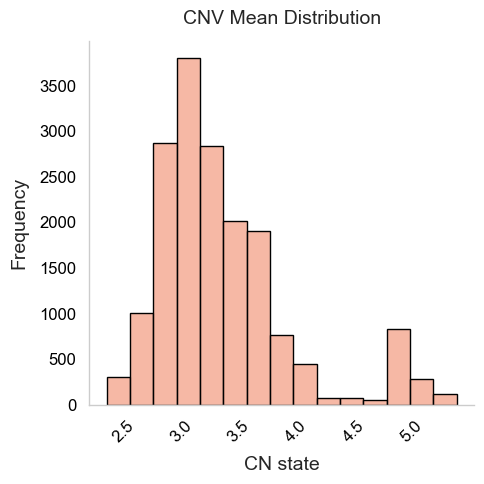

<Figure size 500x500 with 0 Axes>

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


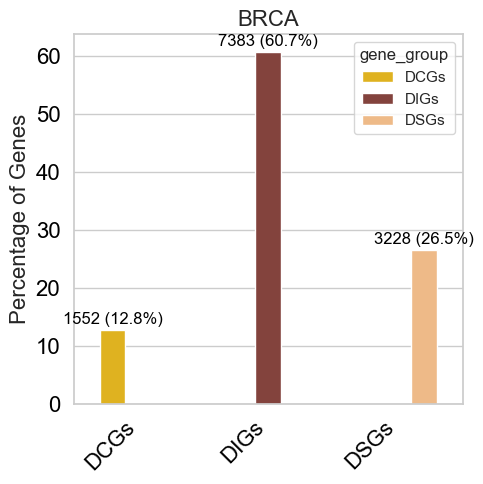

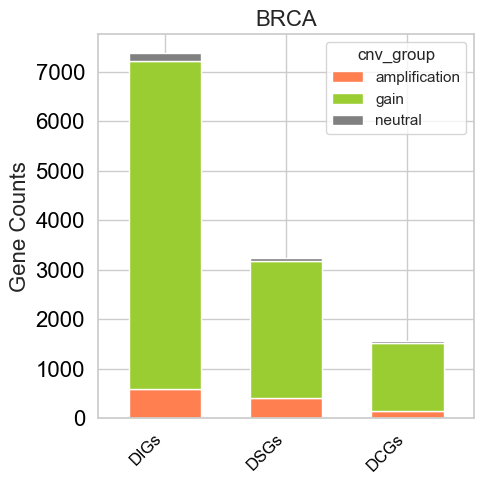

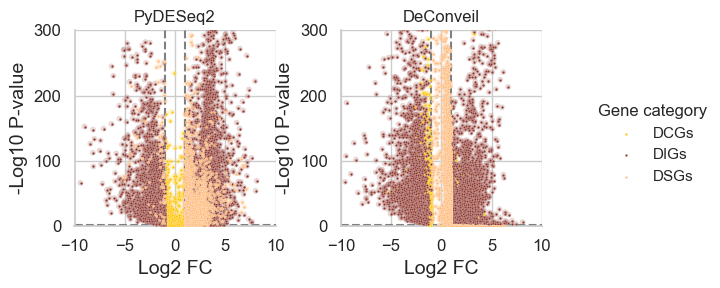

In [149]:
plot_cnv_hist(cnv_mean, binwidth=0.2)
plot_percentage_bar(barplot_data)
plot_stacked_bar(combined_data)
plot_volcano(data_plot, xlim = (-10,10), ylim = (0, 300))